# 2D DPP Galerkin FEM - Monolithic solver

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd
import numpy as np

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Exact solutions

In [3]:
# 1) Create a mesh and function‐spaces.  For example, a unit square:
num_elements_x, num_elements_y = 20, 20
enable_run_on_quads = True
mesh = fd.UnitSquareMesh(
    num_elements_x,
    num_elements_y,
    quadrilateral=enable_run_on_quads,
)

# Vector‐valued H1 space for velocity, and scalar CG1 space for pressure:
V = fd.VectorFunctionSpace(mesh, "CG", 1)
Q = fd.FunctionSpace(mesh, "CG", 1)

# 2) Declare SpatialCoordinate and all parameters:
x, y = fd.SpatialCoordinate(mesh)

# Physical / problem parameters (you can change these as needed):
k1 = fd.Constant(1.0e0)  # example value for k1
k2 = k1 / 1e2  # example value for k2
beta = fd.Constant(1.0e0)  # example value for β
mu = fd.Constant(1.0e0)  # example value for μ

# Define η = sqrt(β (k1 + k2) / (k1 k2))
eta = fd.sqrt(beta * (k1 + k2) / (k1 * k2))

# 3) Build the UFL expressions for u1, p1, u2, p2 exactly as given:
u1_expr = fd.as_vector(
    [
        -k1 * (exp(pi * x) * sin(pi * y)),
        -k1 * (exp(pi * x) * cos(pi * y) - (eta / (beta * k1)) * exp(eta * y)),
    ]
)

p1_expr = (mu / pi) * exp(pi * x) * sin(pi * y) - (mu / (beta * k1)) * exp(eta * y)

u2_expr = fd.as_vector(
    [
        -k2 * (exp(pi * x) * sin(pi * y)),
        -k2 * (exp(pi * x) * cos(pi * y) + (eta / (beta * k2)) * exp(eta * y)),
    ]
)

p2_expr = (mu / pi) * exp(pi * x) * sin(pi * y) + (mu / (beta * k2)) * exp(eta * y)

# 4) Now interpolate each analytic expression into a Firedrake Function:
u1_exact = fd.Function(V, name="u1_analytic")
u1_exact.interpolate(u1_expr)

p1_exact = fd.Function(Q, name="p1_analytic")
p1_exact.interpolate(p1_expr)

u2_exact = fd.Function(V, name="u2_analytic")
u2_exact.interpolate(u2_expr)

p2_exact = fd.Function(Q, name="p2_analytic")
p2_exact.interpolate(p2_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x757dd87a8160>, FiniteElement('Q', quadrilateral, 1), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 15)

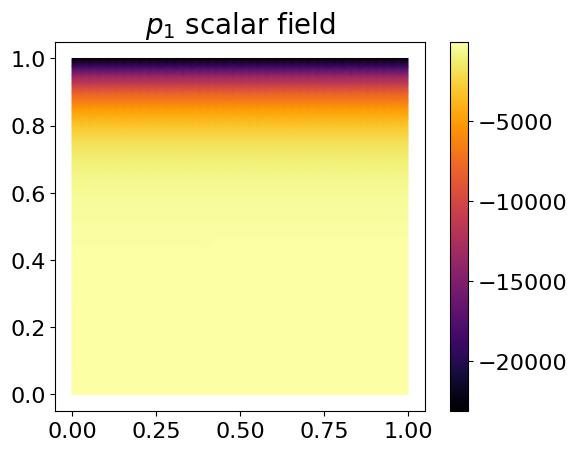

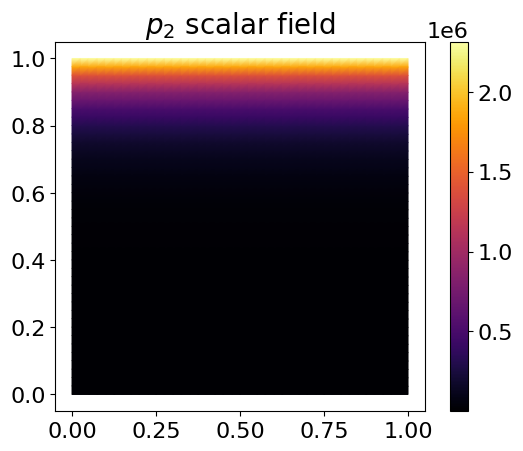

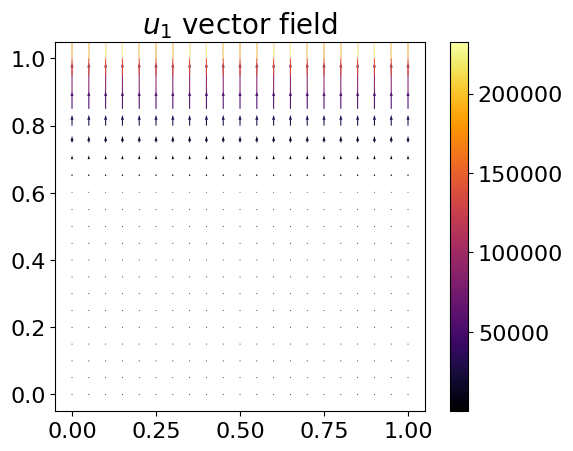

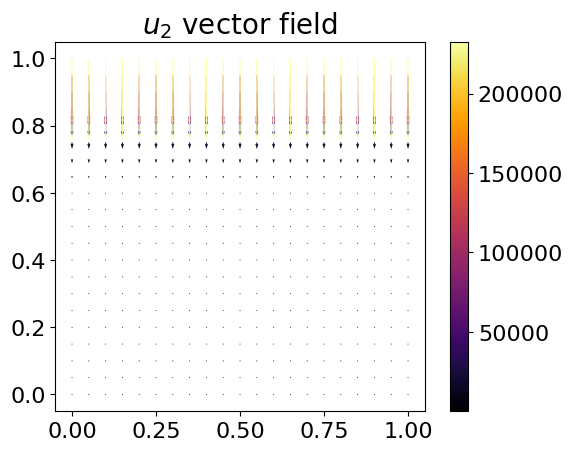

In [4]:
fig, axes = plt.subplots()
contours = fd.tripcolor(p1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.tripcolor(p2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(contours)
plt.show()

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [5]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Solving the problem
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solution = fd.Function(W)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=True)
solver = fd.LinearVariationalSolver(problem, solver_parameters=solver_parameters)
solver.solve()

# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(solution.sub(0))
p2_h.assign(solution.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

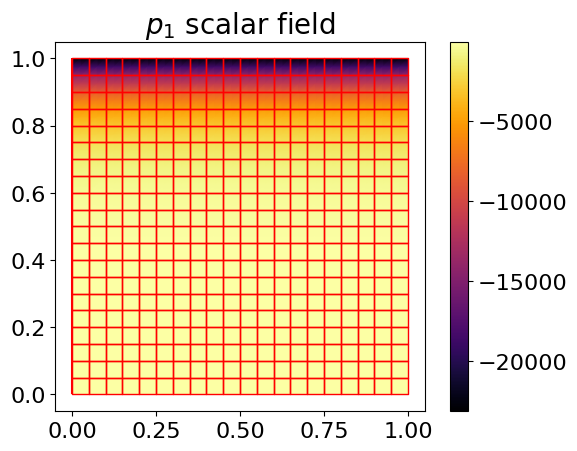

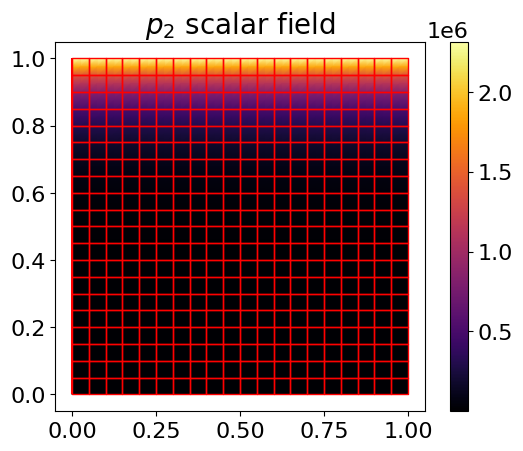

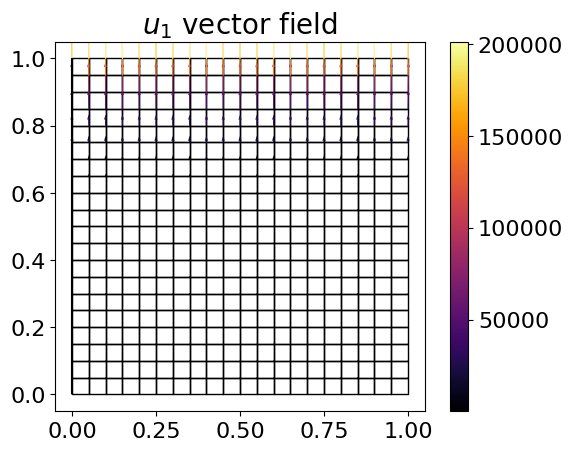

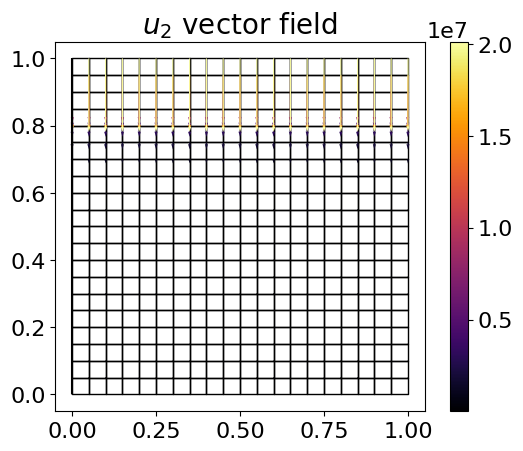

In [6]:
fig, axes = plt.subplots()
colors = fd.tripcolor(p1_h, axes=axes, cmap="inferno")
fd.triplot(mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"})
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
colors = fd.tripcolor(p2_h, axes=axes, cmap="inferno")
fd.triplot(mesh, axes=axes, interior_kw={"edgecolors": "red"}, boundary_kw={"colors": "red"})
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u1_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(colors)
plt.show()

fig, axes = plt.subplots()
fd.triplot(mesh, axes=axes, boundary_kw={"colors": "k"})
colors = fd.quiver(u2_h, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(colors)
plt.show()

In [7]:
def get_xy_coordinate_points(function_space, mesh):
    x, y = fd.SpatialCoordinate(mesh)

    xfunc = fd.Function(function_space).interpolate(x)
    x_points = np.unique(np.array(xfunc.dat.data))

    yfunc = fd.Function(function_space).interpolate(y)
    y_points = np.unique(np.array(yfunc.dat.data))

    return x_points, y_points


def retrieve_solution_on_line_fixed_x(solution, function_space, mesh, x_value):
    _, y_points = get_xy_coordinate_points(function_space, mesh)
    solution_on_a_line = [solution.at([x_value, y_point]) for y_point in y_points]
    solution_on_a_line = np.array(solution_on_a_line)
    return solution_on_a_line

In [8]:
# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_exact, V, mesh, x_mid_point)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_exact, V, mesh, x_mid_point)

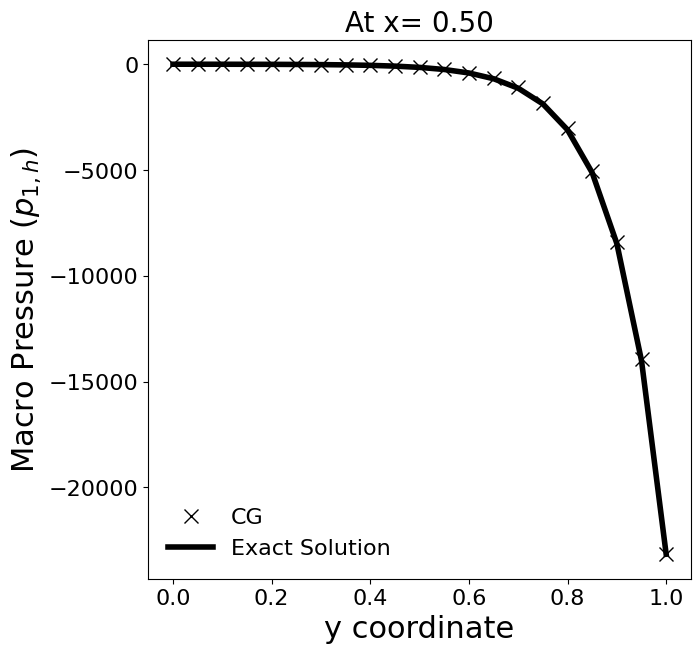

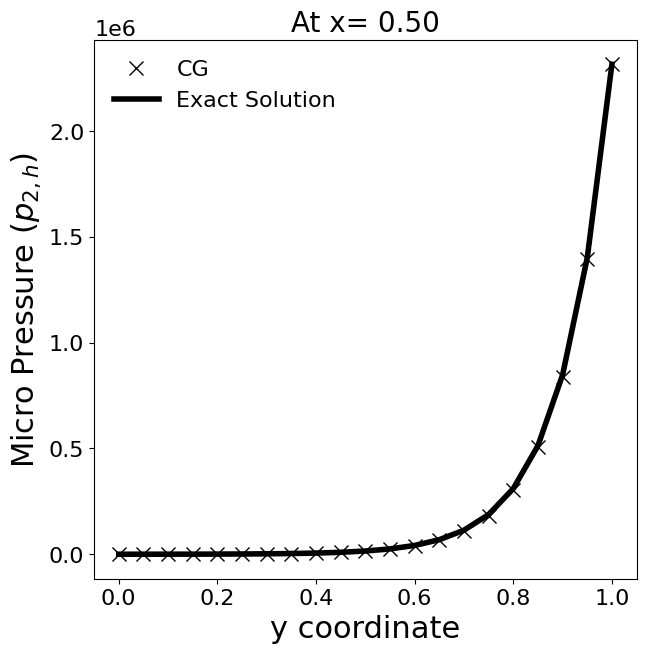

In [9]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [10]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
dpp_fields = fd.Function(W)
p1, p2 = fd.TrialFunctions(W)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

# Solving the problem
solver_parameters = {
    "snes_type": "ksponly",
    "ksp_monitor": None,
    "pmat_type": "aij",
    "mat_type": "aij",
    "ksp_type": "gmres",
    "ksp_rtol": 1.0e-12,
    "ksp_atol": 1.0e-12,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
    "pc_fieldsplit_0_fields": "0",
    "pc_fieldsplit_1_fields": "1",
    "fieldsplit_0": {
        "mat_type": "aij",
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "fieldsplit_1": {
        "mat_type": "aij",
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solution = fd.Function(W)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=True)
solver = fd.LinearVariationalSolver(
    problem, solver_parameters=solver_parameters, options_prefix="dpp"
)
solver.solve()

# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(solution.sub(0))
p2_h.assign(solution.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 7.577694309683e+06
    1 KSP Residual norm 1.156465033078e+05
    2 KSP Residual norm 1.748227203047e+03
    3 KSP Residual norm 1.068809478885e+01
    4 KSP Residual norm 2.490739680499e-02
    5 KSP Residual norm 2.704908412806e-05
    6 KSP Residual norm 2.009859815285e-08


In [11]:
solver_parameters_gmres = {
    "mat_type": "aij",
    "pc_type": "jacobi",
    "ksp_type": "gmres",
    "ksp_rtol": 1.0e-12,
    "ksp_atol": 1.0e-12,
    "ksp_max_it": 5000,
    "ksp_monitor": None,
}
solution_gmres = fd.Function(W)
problem_gmres = fd.LinearVariationalProblem(a, L, solution_gmres, bcs=bcs, constant_jacobian=True)
solver_gmres = fd.LinearVariationalSolver(problem_gmres, solver_parameters=solver_parameters_gmres)
solver_gmres.solve()

    Residual norms for firedrake_5_ solve.
    0 KSP Residual norm 3.656607590335e+06
    1 KSP Residual norm 1.439834371331e+06
    2 KSP Residual norm 7.231201180569e+05
    3 KSP Residual norm 3.966145931345e+05
    4 KSP Residual norm 2.258375976969e+05
    5 KSP Residual norm 1.310187788250e+05
    6 KSP Residual norm 7.665578627384e+04
    7 KSP Residual norm 4.499210209080e+04
    8 KSP Residual norm 2.645627056021e+04
    9 KSP Residual norm 1.560928785340e+04
   10 KSP Residual norm 9.071788171797e+03
   11 KSP Residual norm 5.330059144625e+03
   12 KSP Residual norm 3.127173309080e+03
   13 KSP Residual norm 1.833036078861e+03
   14 KSP Residual norm 1.077155782483e+03
   15 KSP Residual norm 6.318639015824e+02
   16 KSP Residual norm 3.700865341193e+02
   17 KSP Residual norm 2.166636889922e+02
   18 KSP Residual norm 1.261787119404e+02
   19 KSP Residual norm 3.774602225960e+01
   20 KSP Residual norm 1.856329177531e+01
   21 KSP Residual norm 1.076023131037e+01
   22 KSP R

In [12]:
# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_exact, V, mesh, x_mid_point)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_exact, V, mesh, x_mid_point)

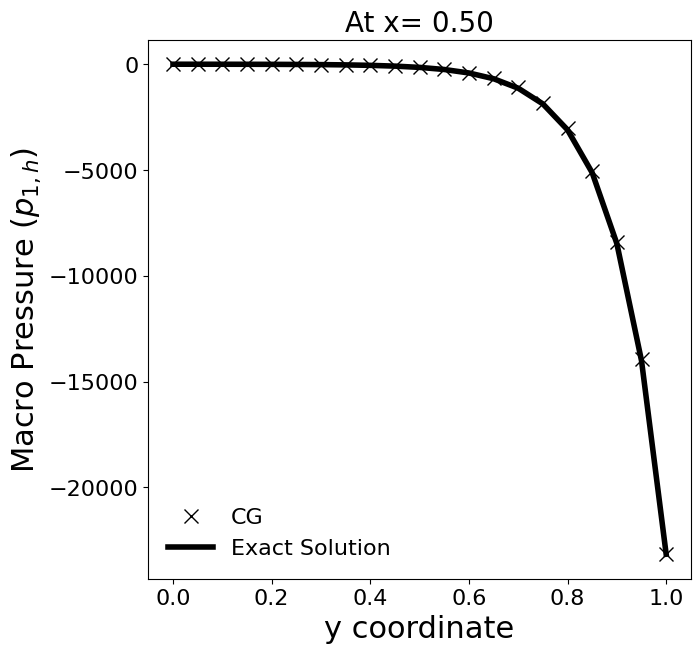

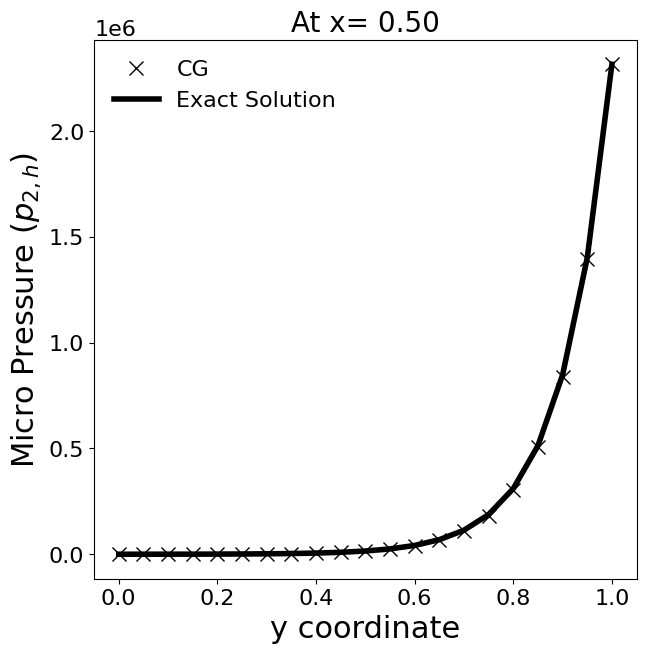

In [13]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Picard (fixed-point) iterations:

In [14]:
# Approximation degree
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)
W = V * V

# Trial and test functions
dpp_fields = fd.Function(W)
p1, p2 = fd.split(dpp_fields)
q1, q2 = fd.TestFunctions(W)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

# Variational form
## Mass transfer term
xi = -beta / mu * (p1 - p2)

## Macro terms
a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
L = f * q1 * dx

## Micro terms
a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
L += f * q2 * dx

solver_parameters_picard = {
    # Iteration monitoring
    "snes_monitor": None,
    # Set nonlinear Richardson (equivalent to Picard)
    "snes_type": "nrichardson",
    "snes_max_it": 15000,
    # The simplest line-search (no extra damping)
    "snes_linesearch_type": "basic",
    "snes_linesearch_damping": 0.5,  # for full step, use 1.0
    # Split by scales
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
    "pc_fieldsplit_0_fields": "0",  # macro
    "pc_fieldsplit_1_fields": "1",  # micro
    # Set the LU solver for each block
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "lu",
    "fieldsplit_0_pc_factor_mat_solver_type": "mumps",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_pc_type": "lu",
    "fieldsplit_1_pc_factor_mat_solver_type": "mumps",
    # Convergence criteria
    "snes_rtol": 1e-5,  # rel tol between Picard iterations
    "snes_atol": 1e-12,
}

F = a - L
problem_picard = fd.NonlinearVariationalProblem(F, dpp_fields, bcs=bcs)
solver_picard = fd.NonlinearVariationalSolver(
    problem_picard, solver_parameters=solver_parameters_picard
)
solver_picard.solve()

  0 SNES Function norm 1.436364896905e+05
  1 SNES Function norm 1.118579121757e+05
  2 SNES Function norm 1.049699684507e+05
  3 SNES Function norm 1.016953010160e+05
  4 SNES Function norm 9.954313799658e+04
  5 SNES Function norm 9.786914726762e+04
  6 SNES Function norm 9.644108091641e+04
  7 SNES Function norm 9.515714883233e+04
  8 SNES Function norm 9.396646068527e+04
  9 SNES Function norm 9.284102164514e+04
 10 SNES Function norm 9.176426131198e+04
 11 SNES Function norm 9.072578032257e+04
 12 SNES Function norm 8.971872898685e+04
 13 SNES Function norm 8.873840683810e+04
 14 SNES Function norm 8.778147144152e+04
 15 SNES Function norm 8.684547002207e+04
 16 SNES Function norm 8.592855097187e+04
 17 SNES Function norm 8.502927999182e+04
 18 SNES Function norm 8.414651940201e+04
 19 SNES Function norm 8.327934684366e+04
 20 SNES Function norm 8.242699925417e+04
 21 SNES Function norm 8.158883346950e+04
 22 SNES Function norm 8.076429801292e+04
 23 SNES Function norm 7.995291256

In [15]:
# Retrieving the solution
p1_h = fd.Function(V, name="p1_h")
p2_h = fd.Function(V, name="p2_h")
p1_h.assign(dpp_fields.sub(0))
p2_h.assign(dpp_fields.sub(1))
u1_h = fd.project(-grad(p1_h), U)
u2_h = fd.project(-grad(p2_h), U)

# Fixed x-point coordinate to slice the solution
x_points, y_points = get_xy_coordinate_points(V, mesh)
x_mid_point = (x_points.min() + x_points.max()) / 2

p1_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_h, V, mesh, x_mid_point)

p2_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_h, V, mesh, x_mid_point)

p1_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p1_exact, V, mesh, x_mid_point)

p2_exact_at_x_mid_point = retrieve_solution_on_line_fixed_x(p2_exact, V, mesh, x_mid_point)

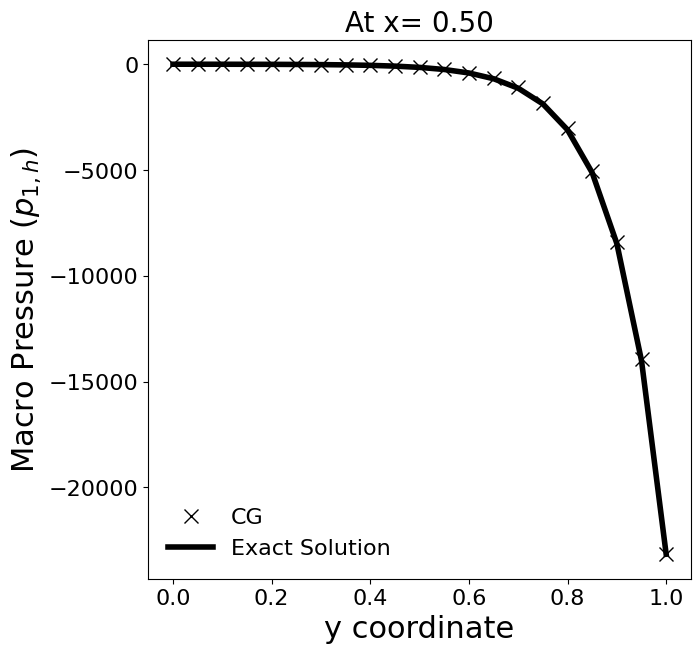

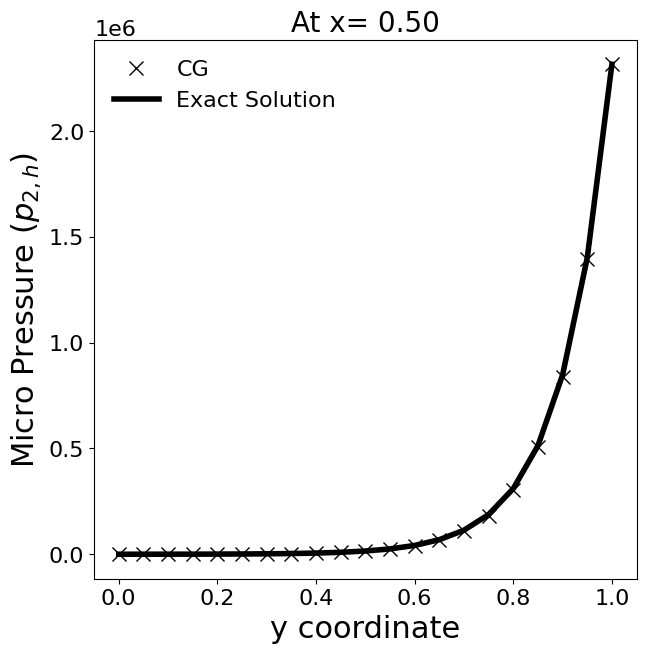

In [16]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_at_x_mid_point, "x", ms=10, lw=4, c="k", label="CG")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

## Case 2